# Simulation of a prism applied to a Non-linear inverse problem using Levenberg-Marquardt Method

## Importing libraries

In [1]:
%matplotlib inline
from fatiando.gridder import regular, spacing
from fatiando.mesher import Prism
from fatiando.utils import ang2vec
from fatiando.gravmag import prism
from fatiando.constants import CM, T2NT
import numpy as np
import matplotlib.pyplot as plt
from visual import histeq

/home/andre/anaconda2/lib/python2.7/site-packages/fatiando/vis/mpl.py:70: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


## Prism parameters

### Dimension of the prism

In [2]:
dimx = 5.  # in mm
dimy = 5.
dimz = 5.

In [3]:
Lx = 1e-3*dimx

In [4]:
Ly = 1e-3*dimy

In [5]:
Lz = 1e-3*dimz

### Sensor-to-sample distance

In [6]:
voo = 500.
dist = voo*1e-6
sts = dist + (0.5*Lz) 

## Parameters for the observation coordinate

In [7]:
Nx = 50
Ny = 50
shape = (Nx,Ny)

In [8]:
xmax = 1e-3*6.
xmin = -xmax
ymax = 1e-3*6.
ymin = -ymax

area = [xmin,xmax,ymin,ymax]

In [9]:
x,y,z = regular(area,shape, -sts)

## Generating the sample

In [10]:
intensity = 0.1
inclination = 90.
declination = 0.

In [11]:
mag = ang2vec(intensity,inclination,declination)

In [12]:
sample = [Prism(-0.5*Lx,0.5*Lx,-0.5*Ly,0.5*Ly,-0.5*Lz,0.5*Lz, props={'magnetization': mag})]

## True parameters

In [13]:
p_true = np.array([voo,intensity]) ## (sensor-to-sample,intensity)

## Calculating the observed data

In [14]:
Bz = prism.bz(x,y,z,sample)

In [15]:
np.random.seed(seed=40)

std_noise = 0.02*np.max(np.abs(Bz))

r = np.random.normal(0.0, std_noise, Nx*Ny)

print '%.3f nT' % std_noise

0.896 nT


In [16]:
Bz_obs = Bz + r

## Calculating the predicted data

In [17]:
def pred_data(x,y,p,sample,inc,dec):
    '''
    Calculate the predicted data.
    '''
    voo = p[0]
    dist = voo*1e-6
    sts = dist + (0.5*Lz) 
    z = -sts*np.ones_like(x)
    
    m = p[1]
    jx = np.cos(np.deg2rad(inc))*np.cos(np.deg2rad(dec))
    jy = np.cos(np.deg2rad(inc))*np.sin(np.deg2rad(dec))
    jz = np.sin(np.deg2rad(inc))
    bz = prism.kernelxz(x,y,z,sample[0])*jx+\
         prism.kernelyz(x,y,z,sample[0])*jy+\
         prism.kernelzz(x,y,z,sample[0])*jz
    bz *= CM*T2NT*m
    return  bz

In [18]:
Bz_pred = pred_data(x,y,p_true,sample,inclination,declination)

## Comparison between observed data and predicted data

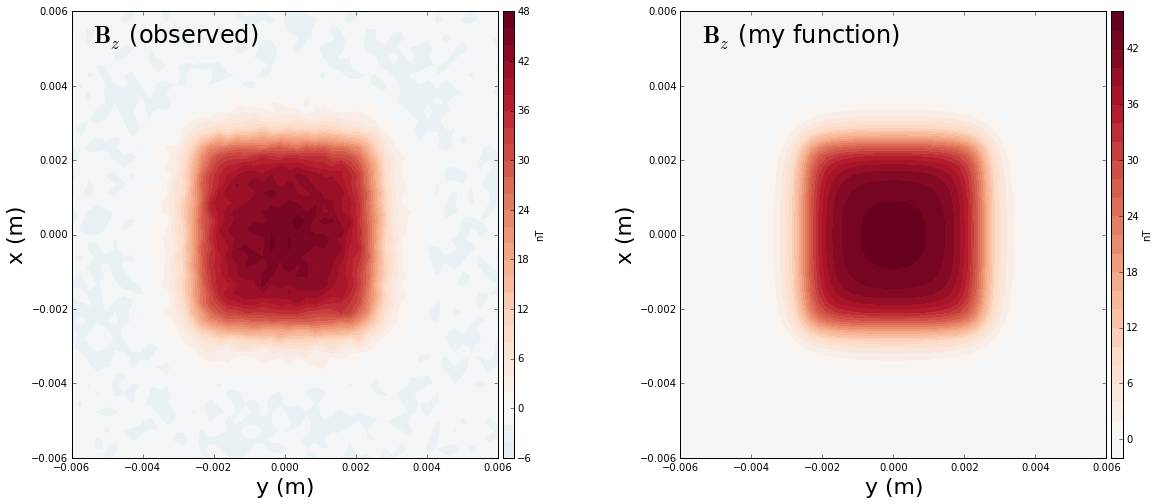

In [19]:
title_font = 22
bottom_font = 16
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
ranges = saturation_factor*np.abs([Bz_obs.max(), Bz_obs.min()]).max()

plt.contourf(y.reshape(shape), x.reshape(shape), Bz_obs.reshape(shape),30, cmap=plt.cm.RdBu_r, vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT')
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.annotate('$\mathbf{B}_z$ (observed)', xy = (0.05, 0.93), 
             xycoords = 'axes fraction', fontsize=24)

plt.subplot(1,2,2)
ranges = saturation_factor*np.abs([Bz_pred.max(), Bz_pred.min()]).max()

plt.contourf(y.reshape(shape), x.reshape(shape), Bz_pred.reshape(shape), 30, cmap=plt.cm.RdBu_r, vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT')
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.annotate('$\mathbf{B}_z$ (my function)', xy = (0.05, 0.93), xycoords = 'axes fraction', fontsize=24)

plt.show()


## Visualization of the data misfit

In [20]:
Nm = 20
m_range = np.linspace(0.01,.2,num=Nm)

In [21]:
Nh = 20
h_range = np.linspace(10.,1000.,num=Nh)

In [22]:
h_range,m_range = np.meshgrid(h_range,m_range)

In [23]:
shape_phi = (Nh,Nm)

In [24]:
misfit = []
for mi,hi in zip (m_range.ravel(),h_range.ravel()):
    p = np.array([hi,mi])
    Bz_pred_it = pred_data(x,y,p,sample,inclination,declination)
    res = Bz_obs - Bz_pred_it 
    misfit.append(np.linalg.norm(res))

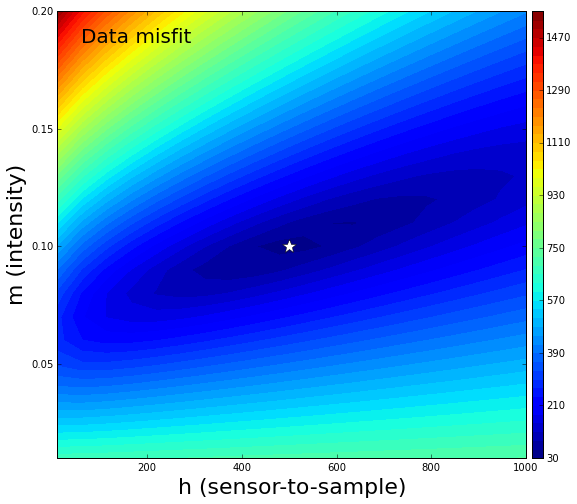

In [25]:
title_font = 22
bottom_font = 16
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(10,8))
plt.contourf(h_range, m_range, np.array(misfit).reshape(shape_phi), 50)
plt.plot(voo,intensity,'w*',markersize=15)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0)
plt.xlabel('h (sensor-to-sample)', fontsize = title_font)
plt.ylabel('m (intensity)', fontsize = title_font)
plt.annotate('Data misfit', xy = (0.05, 0.93), xycoords = 'axes fraction', fontsize=20)

plt.show()

## Calculating the Sensitivity matrix 

In [26]:
def sensitivity(x,y,p,sample,inc,dec):
    '''
    Calculating the sensitivity matrix numerically.
    '''
    dp1 = .01*p[0]
    dp2 = .01*p[1]
    N = len(x)
    
    dh1 = np.array([p[0]+dp1,p[1]])
    dh2 = np.array([p[0]-dp1,p[1]])
    
    dm1 = np.array([p[0],p[1]+dp2])
    dm2 = np.array([p[0],p[1]-dp2])
    
    A = np.empty([N,2])
    A[:,0] = (pred_data(x,y,dh1,sample,inc,dec) - pred_data(x,y,dh2,sample,inc,dec))/(2.*dp1)
    A[:,1] = (pred_data(x,y,dm1,sample,inc,dec) - pred_data(x,y,dm2,sample,inc,dec))/(2.*dp2)
    return A

## Performing the Levenberg-Marquardt method 

In [46]:
itmax = 40
it_max_marq = 20
eps = 1e-10
lamb = 100000000000.


p0 = np.array([100.,.18])

px = [p0[0]]
py = [p0[1]]

phi_it = []
it  = []
for i in range(itmax):
        
    B0 = pred_data(x,y,p0,sample,inclination,declination)
    
    r0 = Bz_obs - B0
    
    phi0 = np.linalg.norm(r0)
    
    for it_marq in range(it_max_marq):
        
        G = sensitivity(x,y,p0,sample,inclination,declination)
        GtG = np.dot(G.T,G)   
        H = GtG + lamb*np.identity(2)        
        B = pred_data(x,y,p0,sample,inclination,declination)
        r = Bz_obs - B        
        grad = - np.dot(G.T,r)        
        dp = np.linalg.solve(H,-grad)
        p0 += dp
        phi = np.linalg.norm(r)        
        dphi = phi-phi0
        
        if (dphi < 0):
            lamb = lamb/2.
        else: 
            lamb = 2.*lamb
        
    condition = np.abs(dphi)/phi0        
    if (condition <= eps):
        break
    
    
    r0 = r
    phi0 = phi
    B0=B
    px.append(p0[0])
    py.append(p0[1])
    phi_it.append(phi0)
    it.append(i)
    
    print lamb
    print p0
    print phi0
       
        

381469.726562
[  1.00000365e+02   7.37042903e-02]
181.35667488
1.45519152284
[  1.65506280e+02   7.83456849e-02]
156.429587463
5.55111512313e-06
[  5.06313554e+02   1.00681668e-01]
44.2482057636


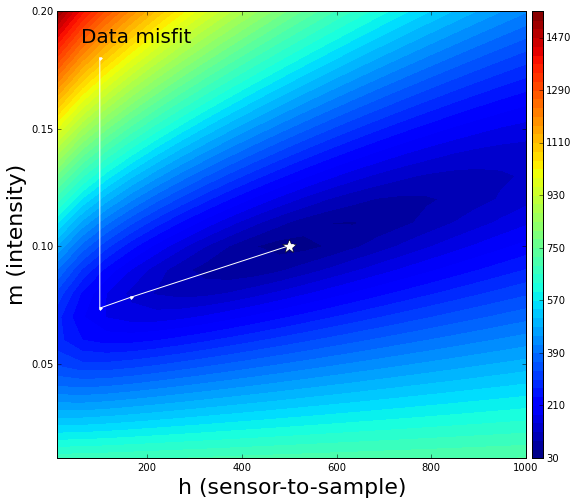

In [47]:
title_font = 22
bottom_font = 16
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(10,8))
plt.contourf(h_range, m_range, np.array(misfit).reshape(shape_phi), 50)
plt.plot(voo,intensity,'w*',markersize=15)
plt.plot(px,py,'w.-')
plt.colorbar(pad=0.01, aspect=40, shrink=1.0)
plt.xlabel('h (sensor-to-sample)', fontsize = title_font)
plt.ylabel('m (intensity)', fontsize = title_font)
plt.annotate('Data misfit', xy = (0.05, 0.93), xycoords = 'axes fraction', fontsize=20)

plt.show()

## Plotting misfit

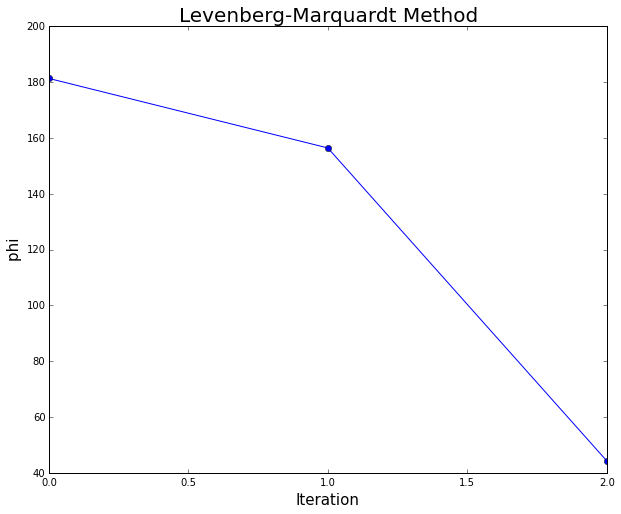

In [48]:
plt.figure(figsize=(10,8))

plt.plot(it, phi_it, 'o-')
plt.title('Levenberg-Marquardt Method',fontsize=20)
plt.ylabel('phi ',fontsize=15)
plt.xlabel('Iteration',fontsize=15)

plt.show()
